In [1]:
## Implementing JPEG

In [12]:
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
import math 
from matplotlib.colors import Normalize
import matplotlib.cm as cm
np.set_printoptions(precision=2,suppress=True)
from sklearn.metrics import mean_squared_error


In [2]:
### Find the size of the input imgae
print(f"The size of the input image is {os.path.getsize('cameraman.tif')} bytes")

The size of the input image is 65240 bytes


In [3]:
def DCTcoefficient(gray_img,B=8):
    h,w = gray_img.shape
    blocksV=h//B
    blocksH=w//B
    vis0 = np.zeros((h,w), np.float32)
    Trans = np.zeros((h,w), np.float32)
    vis0[:h, :w] = gray_img
    for row in range(blocksV):
            for col in range(blocksH):
                    currentblock = cv2.dct(vis0[row*B:(row+1)*B,col*B:(col+1)*B])
                    Trans[row*B:(row+1)*B,col*B:(col+1)*B]=currentblock
    cv2.imwrite('Transformed.jpg', Trans)
    return Trans
# cv2.cv.SaveImage('Transformed.jpg', cv2.cv.fromarray(Trans))

In [4]:
def Qmatrix(a,b,c):
    #     a,b,c= 10,40,20
    Q = np.array([[c,a,b,b,b,b,b,b],
     [a,a,b,b,b,b,b,b],
    [b,b,b,b,b,b,b,b],
    [b,b,b,b,b,b,b,b],
    [b,b,b,b,b,b,b,b],
    [b,b,b,b,b,b,b,b],
    [b,b,b,b,b,b,b,b],
    [b,b,b,b,b,b,b,b]])
    return Q

In [5]:
## Quantization
def quantize(A,Q):
    B = 8
    h,w = A.shape
    blocksV=h//B
    blocksH=w//B
    y = np.zeros((h,w), np.float32)
    for row in range(blocksV):
            for col in range(blocksH):
                    currentblock = A[row*B:(row+1)*B,col*B:(col+1)*B]
                    y[row*B:(row+1)*B,col*B:(col+1)*B]=np.floor(currentblock/Q +0.5)
    return y
    

#     h,w = A.shape
#     y = np.zeros((h,w), np.float32)
#     for i in range(Q.shape[0]):
#         for j in range(Q.shape[1]):
#             y[i,j] = np.floor((A[i,j]/Q[i,j])  + 0.5)
 

In [6]:
# Lossless source coding
# A matrix has all the quantized dct coefficients
import numpy as np
def encode_single(x):
    x = np.int16(x)
    if(x == 0):
        return '0'
    l = int(np.log2(np.abs(x)))
    if(x < 0):
        b = np.binary_repr((abs(x) ^ 2**(l+1)-1),width = l+1)
    else:
        b = np.binary_repr(x)
    return (l+1)*'1' + '0' + b



In [7]:

def bitstream(A,B=8):
    h,w = A.shape
    blocksV=h//B
    blocksH=w//B
    output_stream = ""
    for row in range(blocksV):
            for col in range(blocksH):
                z = A[row*B:(row+1)*B,col*B:(col+1)*B].flatten()
                for i in range(len(z)):
                    output_stream = output_stream+encode_single(z[i])
    with open('bitstream.txt', 'w') as f:
        f.write(output_stream)
    return output_stream
      

In [8]:
def decode(os):
    m = len(os)
    count = 0
    onecount = 0
    x= 0
    D=[]
    while x< m:
        a = int(os[x])
        if a ==1:
            onecount+=1
        elif a==0 and onecount ==0:
            D.append(0)
            count = count+1
        elif a==0 and onecount>0:
            l = 2**onecount
            s = os[x+1:x+onecount+1]
            b = int(s, base=2)
            if b<l//2:
                D.append(b-l+1)
            else:
                D.append(b)
            x+=onecount
            onecount = 0
        x+=1

    return D




In [9]:
def requantize(A,Q,B=8):
    h,w = A.shape
    blocksV=h//B
    blocksH=w//B
    R = np.zeros((h,w), np.float32)
    for row in range(blocksV):
        for col in range(blocksH):
                currentblock = A[row*B:(row+1)*B,col*B:(col+1)*B]
                R[row*B:(row+1)*B,col*B:(col+1)*B]=currentblock*Q
    return R

In [21]:
def iDCTCoefficient(A,B=8):
    h,w = A.shape
    blocksV=h//B
    blocksH=w//B
    vis0 = np.zeros((h,w), np.float32)
    Trans = np.zeros((h,w), np.float32)
    vis0[:h, :w] = A
    for row in range(blocksV):
            for col in range(blocksH):
                    currentblock = cv2.idct(vis0[row*B:(row+1)*B,col*B:(col+1)*B])
                    Trans[row*B:(row+1)*B,col*B:(col+1)*B]=currentblock
    return Trans


In [18]:
def rearrange(decoded):
    decode = np.array(decoded)
    De = np.reshape(decode, (256, 256))
    B = 8
    h,w = 256,256
    blocksV=h//B
    blocksH=w//B
    i = 0
    De = np.zeros((256,256))
    for row in range(blocksV):
            for col in range(blocksH):
                De[row*B:(row+1)*B,col*B:(col+1)*B] = decode[i:i+64].reshape(8,8)
                i+=64    
    return De
    

In [ ]:

B=8 #blocksize
gray_img = cv2.imread('cameraman.tif',0)
# gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# cv2.imshow('Grayscale', gray_img)
cv2.imshow("test", img)
cv2.waitKey(0)
cv2.destroyAllWindows()
# plt.imshow(gray_img)
# h,w = gray_img.shape
# dctI = DCTcoefficient(gray_img,B=8)
# a,b,c= 10,40,20
# Q = Qmatrix(a,b,c)
# print(f"shape of Q-matrix{Q.shape}")

# qdctI = quantize(dctI,Q)
# print(f"shape of qdctI matrix {qdctI.shape}")

# outstream = bitstream(qdctI ,B=8)
# print(f"shape of ostream matrix {len(outstream)}")

# decodes= decode(outstream)
# print(f"shape of decodes matrix {len(decodes)}")
# # print(decodes)

# decodeI = rearrange(decodes)
# print(f"shape of decodeI matrix {decodeI.shape}")

# rdctI = requantize(decodeI,Q, B=8)
# print(f"shape of rdctI matrix{rdctI.shape}")
# IdctI = iDCTCoefficient(rdctI)  


In [40]:
def calmse(a,b,c,prn=False):
    B=8 #blocksize
    gray_img = cv2.imread('cameraman.tif',0)
    dctI = DCTcoefficient(gray_img,B=8)
    Q = Qmatrix(a,b,c)
    qdctI = quantize(dctI,Q)
    outstream = bitstream(qdctI ,B=8)
    decodes= decode(outstream)
    decodeI = rearrange(decodes)
    rdctI = requantize(decodeI,Q, B=8)
    IdctI = iDCTCoefficient(rdctI) 
    if prn ==True:
        cv2.imwrite('Reconstructed_img_a.jpg', IdctI)
        plt.imshow(IdctI)
        print(f"shape of Q-matrix{Q.shape}")
        print(f"shape of quantized dct matrix {qdctI.shape}")
        print(f"length of coded stream {len(outstream)} bits")
        print(f"shape of decoded matrix {len(decodes)}")
        print(f"shape of decodeI matrix {decodeI.shape}")
        print(f"shape of rdctI matrix{rdctI.shape}")
    
    mse = mean_squared_error(gray_img.flatten(),IdctI.flatten())
    print(f"MSE for [a ={a},b = {b},c= {c}]:{mse}")
    return mse, len(outstream)
     


shape of Q-matrix(8, 8)
shape of quantized dct matrix (256, 256)
length of coded stream 100918 bits
shape of decoded matrix 65536
shape of decodeI matrix (256, 256)
shape of rdctI matrix(256, 256)
MSE for [a =10,b = 40,c= 20]:42.42529296875


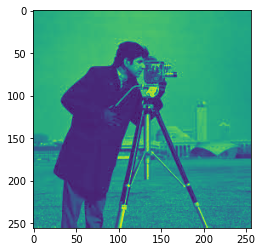

In [41]:
### Calculate the value of mse for a,b,c = 10,40,20
mse, outlen1 = calmse(10,40,20,prn=True)

In [33]:
minmse = 10000000
for a in range(10,101,10):
    for b in range(10,101,10):
        for c in range(10,101,10):
            mse,outlen = calmse(a,b,c,prn=False)
            if outlen<=100918 and mse<minmse:
                minmse = mse
                minindex = [a,b,c]
print(f"The minimum value of mse is {minmse} for a,b,c = {minindex}") 

The minimum value of mse is 32.812583923339844 for a,b,c = [30, 30, 50]


shape of Q-matrix(8, 8)
shape of quantized dct matrix (256, 256)
length of coded stream 100394
shape of decoded matrix 65536
shape of decodeI matrix (256, 256)
shape of rdctI matrix(256, 256)
The mse with [a,b,c] = [30,30,50]:32.812583923339844
The length of output code with [a,b,c] = [30,30,50]:100394


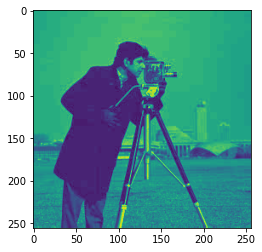

In [35]:
### The image for the optimal a,b,c 
mse, outlen1 = calmse(30,30,50,prn=True)
print(f"The mse with [a,b,c] = [30,30,50]:{mse}")
print(f"The length of output code with [a,b,c] = [30,30,50]:{outlen1}")

In [ ]:
## Reconstruction of x
# xhat = np.zeros((h,w), np.float32)
# for i in range(Q.shape[0]):
#     for j in range(Q.shape[1]):
#         xhat[i,j] = y[i,j]*Q[i,j]


In [ ]:
# row, col = gray_img.shape
# newI = np.zeros(shape=gray_img.shape, dtype=np.uint8)
# for k1 in range(row):
#     for k2 in range(col):
#         for n1 in range(row):
#             for n2 in range(col):
#                 newI[k1][k2]+=gray_img[n1][n2]*math.cos(math.pi*k1*(n1+0.5)/row)*math.cos(math.pi*k2*(n1+0.5)/col)